Logistic Regression( binary ) 
- logistic function(= sigmoid) 함수 이용

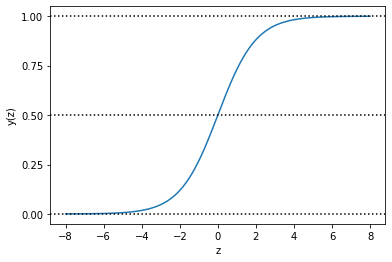

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(input):
  return 1.0/(1+np.exp(-input))

z = np.linspace(-8,8,1000)
y = sigmoid(z)

plt.plot(z,y)
plt.axhline(y=0, ls='dotted', color='k')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.axhline(y=1, ls='dotted', color='k')
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('z')
plt.ylabel('y(z)')
plt.show()

In [21]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/ML&DM/Mechine_Learning/ctr_data_20000.csv')
data = data.drop(['id', 'hour','device_id', 'device_ip'], axis =1) # 쓸모없는 칼럼들 삭제

In [22]:
from sklearn.feature_extraction import DictVectorizer # feature들을 one-hot encoding으로 바꿔줌

data_x = data.loc[:, data.columns != 'click'].astype('str')
data_y = data.loc[:, data.columns == 'click'].astype('int').values.ravel()

train_x, test_x = data_x[0:15000], data_x[15000:]
train_y, test_y = data_y[0:15000], data_y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse=False)
onehot_train_x = dict_one_hot_encoder.fit_transform(train_x.to_dict('records'))
onehot_test_x = dict_one_hot_encoder.transform(test_x.to_dict('records'))

print(train_x.shape)
print(onehot_train_x.shape)

(15000, 19)
(15000, 3244)


In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

parameters = {'eta0' : [0.1,0.01,0.001]}
sgd_lr = SGDClassifier(loss = 'log', fit_intercept=True, penalty='l1')
# penalty : l1, l2, elasticnet 3가지 중 하나로 regularization term을 줄 수 있음
grid_search = GridSearchCV(sgd_lr, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(onehot_train_x, train_y)

sgd_lr_best = grid_search.best_estimator_
pos_prob = sgd_lr_best.predict_proba(onehot_test_x)[:,1]
print("The ROC AUC on testing set is {0:3f}".format(roc_auc_score(test_y, pos_prob)))

The ROC AUC on testing set is 0.710712


Multiclasses logistic regression 
- Softmax function 이용

In [24]:
import nltk

nltk.download('names')
nltk.download('wordnet')

from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

def clean_text(docs):
  cleaned_docs = []
  for doc in docs : 
    lemmatized_list = [ lemmatizer.lemmatize(word.lower())
    for word in doc.split()
    if word.isalpha() and word not in all_names]
    cleaned_docs.append(' '.join(lemmatized_list))
    
    return cleaned_docs

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

data_train = fetch_20newsgroups(subset = 'train', categories = None, random_state = 42)
data_test = fetch_20newsgroups(subset = 'test', categories = None, random_state = 42)

cleaned_train = clean_text(data_train.data)
label_train = data_train.target
cleaned_test = clean_text(data_test.data)
label_test = data_test.target

tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 1,
                                  stop_words='english', max_features=4000)
term_docs_train = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test = tfidf_vectorizer.transform(cleaned_test)

In [35]:
from sklearn.model_selection import GridSearchCV

parameters = {'penalty':['l2', None], 'alpha':[1e-07,1e-06,1e-05,1e-04],'eta0':[0.01,0.1,1,10]}
sgd_lr = SGDClassifier(loss='log', learning_rate='constant', eta0 = 0.01, fit_intercept = True)

grid_search = GridSearchCV(sgd_lr, parameters, n_jobs=-1, cv=3)
grid_search.fit(term_docs_train, label_train)
print(grid_search.best_params_)

ValueError: ignored

In [ ]:
sgd_lr_best = grid_search.best_estimator_
accuracy = sgd_lr_best.score(term_docs_test, label_test)
print("The accuarcy on testing set is {0:1f}".format(accuracy*100))